Loading and normalizing CIFAR10

In [45]:
import torch
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


torchvision.datasets.CIFAR10
>torchvision.datasets.CIFAR10(root, train=True, transform=None, target_transform=None, download=False)  
root (string) – Root directory of dataset where directory cifar-10-batches-py exists or will be saved to if download is set to True.  
train (bool, optional) – If True, creates dataset from training set, otherwise creates from test set.  
transform (callable, optional) – A function/transform that takes in an PIL image and returns a transformed version. E.g, transforms.RandomCrop  
target_transform (callable, optional) – A function/transform that takes in the target and transforms it.  
download (bool, optional) – If true, downloads the dataset from the internet and puts it in root directory. If dataset is already downloaded, it is not downloaded again.  

注意，如果上述函数的downloard参数为True的话，程序会自动将数据集下载到指定目录，由于下载比较慢，最好手动下载。

torch.utils.data.DataLoader
>torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, sampler=None, batch_sampler=None, num_workers=0, collate_fn=<function 
>default_collate>, pin_memory=False, drop_last=False, timeout=0, worker_init_fn=None)
dataset (Dataset) – dataset from which to load the data.  
batch_size (int, optional) – how many samples per batch to load (default: 1).  
shuffle (bool, optional) – set to True to have the data reshuffled at every epoch (default: False).  

shffule=True在表示不同批次的数据遍历时，打乱顺序。num_workers=2表示使用两个子进程来加载数据

transforms.Compose:作用是组合不同的transforms

transforms.ToTensor:作用是数据预处理，将原数据转化为[0,1]的tensor数据

transforms.Normalize:数据归一化，两个参数分别是mean和std, channel= (channel-mean)/std

In [39]:
#dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(len(trainset))
print(len(trainloader))

50000
12500


show some images for fun

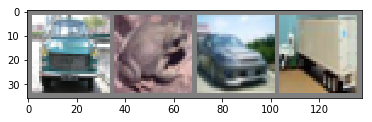

  car  frog   car truck


In [40]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [41]:
#define a cnn model
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [42]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [43]:
#training
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.161
[1,  4000] loss: 1.879
[1,  6000] loss: 1.733
[1,  8000] loss: 1.626
[1, 10000] loss: 1.538
[1, 12000] loss: 1.480
[2,  2000] loss: 1.409
[2,  4000] loss: 1.365
[2,  6000] loss: 1.381
[2,  8000] loss: 1.327
[2, 10000] loss: 1.331
[2, 12000] loss: 1.292
Finished Training


In [44]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 58 %
Accuracy of   car : 67 %
Accuracy of  bird : 27 %
Accuracy of   cat : 52 %
Accuracy of  deer : 44 %
Accuracy of   dog : 21 %
Accuracy of  frog : 72 %
Accuracy of horse : 61 %
Accuracy of  ship : 71 %
Accuracy of truck : 65 %
